#### 해석
- 본 Task는 다음의 사항이 성능에 큰 영향을 미치는 것으로 파악됌.
    - 1. 전처리 과정 (Image -> Binary -> Skeleton) 중 적절한 threshold를 활용해야함
        - 이전에 사용했던 Otsu Threshold는 높은 값 (약 79)을 이진화 임계치로 사용하기 때문에, Noise뿐만 아니라 디테일한 정보가 없어져, 분기점 (Bifurcation Point)가 많이 손실되어, branch의 길이가 정답과는 많이 차이가났음
    - 2. 분기점 추적 (Trace Branch)
        - 본 코드를 수정하면서 정답을 유도할 수 있었음.
        - 기존 코드는 upper-left에서 bottom-right 방향으로만 내려가면서 찾는 알고리즘 이였으나, 본 알고리즘을 중앙을 기준으로 8개의 방향을 모두 돌아다니며 탐색하게 수정하였음
        - 이전과 탐색하는 알고리즘 자체가 달라지지는 않았지만,8-connectivity 룰에 의해서 8개의 방향을 모두 확인함
            - 교수님께서 언급하신 360도 시계방향으로 회전하면 탐색하는 것을 구현

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from tqdm import tqdm
from skimage.filters import roberts, sobel
from skimage.segmentation import clear_border
from skimage.morphology import disk, binary_erosion, binary_closing

# Skeletonize
from skimage.morphology import skeletonize

from collections import Counter

from scipy import ndimage as ndi
from skimage.filters import roberts, sobel

from skimage.segmentation import clear_border
from skimage.morphology import disk, binary_erosion, binary_closing

### Trial 2

#### 1. 전처리 (Image -> Binary -> Skeleton)
- 최대한 노이즈만 없애고, 디테일한 부분을 살리는 낮은 임계치 활용(3)

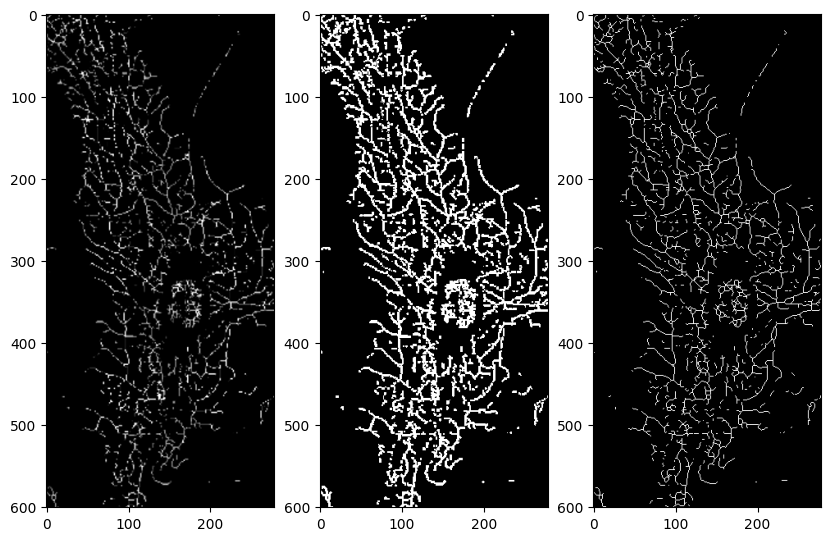

In [7]:
path = './sample.png'

image = cv2.imread(path,2)
_, binary = cv2.threshold(image, 3, 255, cv2.THRESH_BINARY)

skeleton = skeletonize(binary)

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(binary, cmap='gray')
ax[2].imshow(skeleton, cmap='gray')

#### 2. 분기점 탐지
- 기존과 동일하게 활용

In [8]:
# Find bifurcation points in the skeleton
bifurcation_points = []
for i in range(1, skeleton.shape[0] - 1):
    for j in range(1, skeleton.shape[1] - 1):

        if skeleton[i, j] == 1:

            neighbors = sum(skeleton[i + di, j + dj] for di in range(-1, 2) for dj in range(-1, 2) if (di, dj) != (0, 0))
            if neighbors == 3:
                bifurcation_points.append((i, j))

print(f'The number of bifurcation points: {len(bifurcation_points)}')

The number of bifurcation points: 1405


#### 3. 분기점 기준 branch 탐지 (8-connectivity rule, 8방향 탐지)

In [10]:
import numpy as np

def trace_all_branches_from_bifurcation(skel, bifurcation_point):
    # ☘️ 8방향 생성 
    directions = [(di, dj) for di in range(-1, 2) for dj in range(-1, 2) if (di, dj) != (0, 0)]
    branch_lengths = []

    # ☘️ 각 분기점에서 각 방향 돌면서 탐지
    for d in directions:
        branch_length = 0
        current_point = bifurcation_point
        while True:
            i, j = current_point
            next_i, next_j = i + d[0], j + d[1]
            # Check bounds before accessing the array to avoid index errors
            if (0 <= next_i < skel.shape[0]) and (0 <= next_j < skel.shape[1]) and skel[next_i, next_j] == 1:
                branch_length += 1
                current_point = (next_i, next_j)
            else:
                break
        if branch_length > 2:
            branch_lengths.append(branch_length)
    
    return branch_lengths


# Trace and count branches from each bifurcation point
all_branch_lengths = []
for bifur_point in bifurcation_points:
    branch_lengths = trace_all_branches_from_bifurcation(skeleton, bifur_point)
    all_branch_lengths.append((bifur_point, branch_lengths))

#### 유효 브랜치 추출
- branch가 갖는 point가 2개 이하인 것은 제외

In [11]:
valid_branches = []
for each_branch_lengths in all_branch_lengths:
    bif_point = each_branch_lengths[0]
    lengths = each_branch_lengths[1]

    if (np.array(lengths) >= 3).any():
        valid_idx = np.where(np.array(lengths) >= 3)[0]
        length_buffer = []
        for each_idx in valid_idx:
            length_buffer.append(lengths[each_idx])
        valid_branches.append(max(length_buffer))

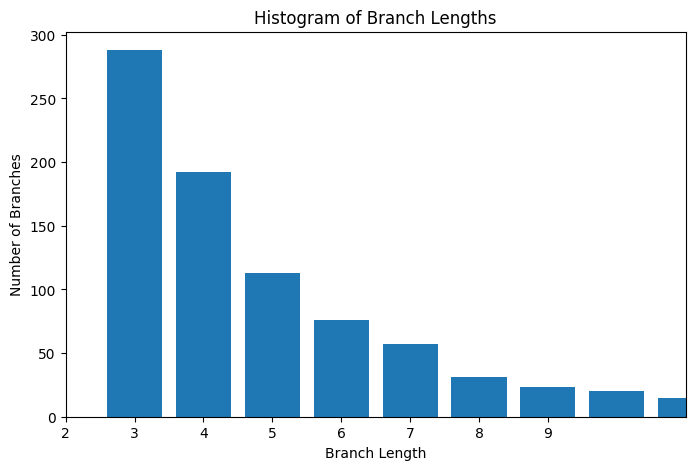

In [17]:
counts = [valid_branches.count(length) for length in valid_branches]

plt.figure(figsize=(8, 5))
plt.bar(valid_branches, counts)

plt.xlabel('Branch Length')
plt.ylabel('Number of Branches')
plt.xticks(range(3, 10))
plt.xticks(range(1, 10))
plt.xlim(2, 11)
plt.title('Histogram of Branch Lengths')
plt.show()